Style transfer is the technique of reconstructing images in the style of another image.

In [57]:
import pandas as pd
import numpy as np
import os
from keras import backend as K
from keras.preprocessing.image import load_img, save_img, img_to_array
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
from keras import optimizers

In [58]:
from scipy.optimize import fmin_l_bfgs_b
from keras.applications.vgg19 import VGG19

In [59]:
StylePath = "C:\\Users\\mawat\\Downloads\\Style neural network\\Best Artworks of All Time\\images\\images"
ContentPath = "C:\\Users\\mawat\\Downloads\\Style neural network\\Google Scraped Image Dataset\\validation\\validation\\travel and adventure"

In [60]:
base_image_path = ContentPath + "\\12.jpg"
style_image_path = StylePath + "\\Pablo_Picasso\\Pablo_Picasso_79.jpg"

In [61]:
#dimensions of the generated picture
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

VGGNet was invented by VGG (Visual Geometry Group) from University of Oxford, Though VGGNet was the 1st runner-up, not the winner of the ILSVRC (ImageNet Large Scale Visual Recognition Competition) 2014 in the classification task, which has significantly improvement over ZFNet (The winner in 2013) and AlexNet (The winner in 2012), VGGNet beats the GoogLeNet and won the localization task in ILSVRC 2014.

VGG19 is a model, with weights pre-trained on ImageNet.ImageNet, is a dataset of over 15 millions labeled high-resolution images with around 22,000 categories. ILSVRC uses a subset of ImageNet of around 1000 images in each of 1000 categories. In all, there are roughly 1.3 million training images, 50,000 validation images and 100,000 testing images.

In [62]:
def preprocess_image(image_path):
    from keras.applications import vgg19
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    img = vgg19.preprocess_input(img)
    return img

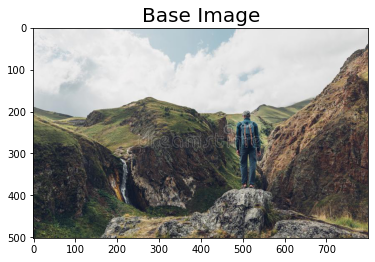

In [63]:
plt.figure()
plt.title("Base Image", fontsize = 20)
img1 = load_img(ContentPath + "\\12.jpg")
plt.imshow(img1)

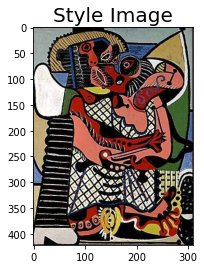

In [64]:
plt.figure()
plt.title('Style Image', fontsize = 20)
img1 = load_img(StylePath + "\\Pablo_Picasso\\Pablo_Picasso_79.jpg")
plt.imshow(img1)

In [65]:
#get tensor representations of the image
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_image_path))

In [66]:
K.image_data_format()

'channels_last'

Think of Variable in tensorflow as a normal variables which we use in programming languages. We initialize variables, we can modify it later as well. Whereas placeholder doesn’t require initial value. Placeholder simply allocates block of memory for future use. Later, we can use feed_dict to feed the data into placeholder. By default, placeholder has an unconstrained shape, which allows you to feed tensors of different shapes in a session.

In [67]:
#this will contain the generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

In [68]:
#combining the 3 images into a single keras tensor
input_tensor = K.concatenate([base_image, style_reference_image, combination_image], axis = 0)

In [69]:
#we will build the VGG19 network with the 3 images as input
#the model will be loaded with pre-trained ImageNet weights
vgg19_weights = "C:\\Users\\mawat\\Downloads\\Style neural network\\VGG-19\\vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5\\vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
model = VGG19(input_tensor = input_tensor, include_top = False, weights = vgg19_weights)
print('Model loaded.')

Model loaded.


Athough Vgg19 is basically used for Classification purpose, but here our objective is not to classify rather our objective is to transform a image, so we do not need all the layers of vgg19, we have specially excluded those layers which are used for classification.

In [70]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1',
                'block5_conv1'
               ]
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [71]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
print(outputs_dict['block5_conv2'])

Tensor("block5_conv2/Relu:0", shape=(3, 25, 39, 512), dtype=float32)


In [72]:
#an auxiliary loss function designed to maintain the content of the base image in the generated image
def get_content_loss(base_content, target):
    return K.sum(K.square(target - base_content))

In [73]:
import tensorflow as tf
def gram_matrix(input_tensor):
    assert K.ndim(input_tensor) == 3
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a = True)
    return gram

def get_style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C))

In [74]:
content_weight = 0.025
style_weight = 1.0

#combining these loss functions into a single scalar
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
print('Layer Feature for Contnet Layers ::' + str(layer_features))
print('Base Image Feature ::' + str(base_image_features))
print('Combination Image Feature for Content Layers ::' + str(combination_features) + '\n')
loss = loss + content_weight * get_content_loss(base_image_features, combination_features)

feature_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    print('Layer Feature for Style Layers ::' + str(layer_features))
    print('Style Image Feature :: ' + str(style_reference_features))
    print('Combination Image Feature for Style Layers:: ' + str(combination_features) + '\n')
    sl = get_style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl

Layer Feature for Contnet Layers ::Tensor("block5_conv2/Relu:0", shape=(3, 25, 39, 512), dtype=float32)
Base Image Feature ::Tensor("strided_slice:0", shape=(25, 39, 512), dtype=float32)
Combination Image Feature for Content Layers ::Tensor("strided_slice_1:0", shape=(25, 39, 512), dtype=float32)

Layer Feature for Style Layers ::Tensor("block1_conv1/Relu:0", shape=(3, 400, 637, 64), dtype=float32)
Style Image Feature :: Tensor("strided_slice_2:0", shape=(400, 637, 64), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_3:0", shape=(400, 637, 64), dtype=float32)

Layer Feature for Style Layers ::Tensor("block2_conv1/Relu:0", shape=(3, 200, 318, 128), dtype=float32)
Style Image Feature :: Tensor("strided_slice_6:0", shape=(200, 318, 128), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_7:0", shape=(200, 318, 128), dtype=float32)

Layer Feature for Style Layers ::Tensor("block3_conv1/Relu:0", shape=(3, 100, 159, 256), dtype

This deprocess_image function is used return the original format of the Final image after transformation which could be easily read and displayed by Matplotlib.

In [96]:
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
        
        #Remove zero-center by mean pixel
    x[:, :, 0] = x[:, :, 0] + 103.939
    x[:, :, 1] = x[:, :, 1] + 116.779
    x[:, :, 2] = x[:, :, 2] + 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [76]:
#tf.compat.v1.disable_eager_execution()
grads = K.gradients(loss, combination_image)
grads

[<tf.Tensor 'gradients/concat_grad/Slice_2:0' shape=(1, 400, 637, 3) dtype=float32>]

In [77]:
outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs = outputs + grads
else:
    outputs.append(grads)
f_outputs = K.function([combination_image], outputs)
f_outputs

Athough there are various optimizers but we have used L-BFGS optimizer in this case.

In [78]:
#run scipy-based optimization (L-BFGS) over the pixels of the generated image so as to minimize the neural style loss
x_opt = preprocess_image(base_image_path)

In [89]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

The purpose of this Evaluator class is to avoid the error 'numpy.ndarray' object is not callable error with optimize.minimize while running the L-BFGS optimizer for loss minimization.
You should pass the function itself to minimize, instead of a evaluated value.

In [90]:
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None
        
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [91]:
evaluator = Evaluator()

In [92]:
iterations=10
# Store our best result
best_loss, best_img = float('inf'), None
for i in range(iterations):
    print('Start of iteration', i)
    x_opt, min_val, info= fmin_l_bfgs_b(evaluator.loss, 
                                        x_opt.flatten(), 
                                        fprime=evaluator.grads,
                                        maxfun=20,
                                        disp=True,
                                       )
    print('Current loss value:', min_val)
    if min_val < best_loss:
        # Update best loss and best image from total loss. 
        best_loss = min_val
        best_img = x_opt.copy()

Start of iteration 0
Current loss value: 3.0253027e+22
Start of iteration 1
Current loss value: 9.877485e+21
Start of iteration 2
Current loss value: 5.208405e+21
Start of iteration 3
Current loss value: 3.476302e+21
Start of iteration 4
Current loss value: 2.721577e+21
Start of iteration 5
Current loss value: 2.1374174e+21
Start of iteration 6
Current loss value: 1.79842e+21
Start of iteration 7
Current loss value: 1.5888853e+21
Start of iteration 8
Current loss value: 1.4007691e+21
Start of iteration 9
Current loss value: 1.2692913e+21


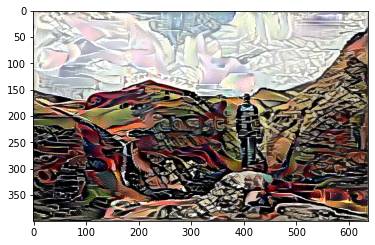

In [97]:
#save the current generated image
imgx = deprocess_image(best_img.copy())
plt.imshow(imgx)

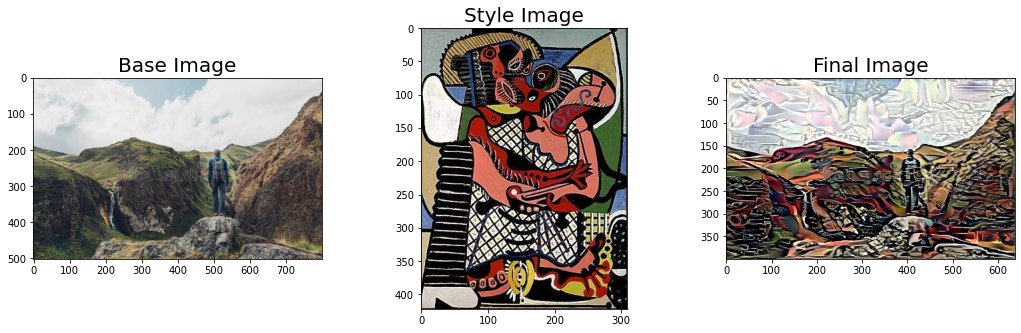

In [101]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title('Base Image', fontsize = 20)
img_base = load_img(base_image_path)
plt.imshow(img_base)

plt.subplot(5, 5, 1+1)
plt.title('Style Image', fontsize = 20)
img_style = load_img(style_image_path)
plt.imshow(img_style)

plt.subplot(5, 5, 1+2)
plt.title('Final Image', fontsize = 20)
plt.imshow(imgx)

This function Run_Style_Transfer is nothing but combination of all the above code that is discussed in the above cells part by part. It returns the final image after style transfer between two images.

In [102]:
def preprocess_image_instantiator(image_path, img_nrows, img_ncols):
    from keras.applications import vgg19
    img = load_img(image_path, target_size = (img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    img = vgg19.preprocess_input(img)
    return img

In [106]:
def Run_StyleTransfer(base_image_path, style_image_path):
    
    width, height = load_img(base_image_path).size
    img_nrows = 400
    img_ncols = int(width * img_nrows / height)
    
    base_image = K.variable(preprocess_image_instantiator(base_image_path,img_nrows,img_ncols))
    style_reference_image = K.variable(preprocess_image_instantiator(style_image_path,img_nrows,img_ncols))
    
    if K.image_data_format() == 'channels_first':
        combination_image = K.placeholder((1,3,img_nrows, img_ncols))
    else:
        combination_image = K.placeholder((1,img_nrows, img_ncols,3))
        
    input_tensor = K.concatenate([base_image,
                                  style_reference_image,
                                  combination_image
                                  ], axis=0)
    from keras.applications.vgg19 import VGG19
    vgg19_weights = "C:\\Users\\mawat\\Downloads\\Style neural network\\VGG-19\\vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5\\vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
    model = VGG19(input_tensor=input_tensor,
                  include_top = False,
                  weights=vgg19_weights)
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
    
    content_weight =0.025 
    style_weight =1.0
    
    # combine these loss functions into a single scalar
    loss = K.variable(0.0)
    layer_features = outputs_dict['block5_conv2']
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    #print('Layer Feature for Content Layers :: '+str(layer_features))
    #print('Base Image Feature :: '+str(base_image_features))
    #print('Combination Image Feature for Content Layers:: '+str(combination_image_features))
    loss = loss + content_weight * get_content_loss(base_image_features,
                                          combination_features)

    feature_layers = ['block1_conv1', 'block2_conv1',
                      'block3_conv1', 'block4_conv1',
                      'block5_conv1']
    for layer_name in feature_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        #print('Layer Feature for Style Layers :: '+str(layer_features))
        #print('Style Image Feature :: '+str(style_reference_features))
        #print('Combination Image Feature for Style Layers:: '+str(combination_features))
        sl = get_style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(feature_layers)) * sl
        
    grads = K.gradients(loss, combination_image)
    
    outputs = [loss]
    if isinstance(grads, (list,tuple)):
        outputs += grads
    else:
        outputs.append(grads)
    f_outputs = K.function([combination_image], outputs)
    
    x_opt = preprocess_image(base_image_path)
    
    evaluator = Evaluator()
    iterations=200
    # Store our best result
    best_loss, best_img = float('inf'), None
    for i in range(iterations):
        #print('Start of iteration', i)
        x_opt, min_val, info= fmin_l_bfgs_b(evaluator.loss, 
                                            x_opt.flatten(), 
                                            fprime=evaluator.grads,
                                            maxfun=20,
                                            disp=True,
                                           )
        #print('Current loss value:', min_val)
        if min_val < best_loss:
            # Update best loss and best image from total loss. 
            best_loss = min_val
            best_img = x_opt.copy()
    imgx = deprocess_image(best_img.copy())
    
    return imgx

In [ ]:
base_image_path_1 = "C:\\Users\\mawat\\Downloads\\Style neural network\\Google Scraped Image Dataset\\images\\images\\travel and  adventure\\Places365_val_00005732.jpg"
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Base Image",fontsize=20)
img_base = load_img(base_image_path_1)
plt.imshow(img_base)

style_image_path_1 = "C:\\Users\\mawat\\Downloads\\Style neural network\\Best Artworks of All Time\\images\\images\\Paul_Klee\\Paul_Klee_97.jpg"
plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img_style = load_img(style_image_path_1)
plt.imshow(img_style)

plt.subplot(5,5,1+2)
imgg = Run_StyleTransfer(base_image_path_1, style_image_path_1)
plt.title("Final Image",fontsize=20)
plt.imshow(imgg)